In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("benjaminawd/new-york-times-articles-comments-2020")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-york-times-articles-comments-2020


In [2]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sentence_transformers import SentenceTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ---------------------------------------
# Data Preprocessing
# ---------------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

# Load your dataset
df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

# Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = model.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = model.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = model.encode(df['section'].tolist(), show_progress_bar=True)

# Numeric Features
df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['interaction'] = df['word_count'] * df['headline_wc']

num_feats = df[['word_count', 'headline_wc', 'abstract_wc', 'interaction']].values
scaler = StandardScaler()
num_feats_scaled = scaler.fit_transform(num_feats)

# Target
y = np.log1p(df['n_comments'].values)

# Train-test split
X1_train, X1_test, \
X2_train, X2_test, \
X3_train, X3_test, \
X4_train, X4_test, \
y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_feats_scaled, y, 
    test_size=0.2, random_state=42
)

# ---------------------------------------
# Model Definition
# ---------------------------------------
# Inputs
inp_headline = Input(shape=(384,), name='headline_emb')
inp_abstract = Input(shape=(384,), name='abstract_emb')
inp_section = Input(shape=(384,), name='section_emb')
inp_numeric = Input(shape=(4,), name='numeric_feats')

# Dense paths
h1 = Dense(128, activation='relu')(inp_headline)
h2 = Dense(128, activation='relu')(inp_abstract)
h3 = Dense(128, activation='relu')(inp_section)
h4 = Dense(32, activation='relu')(inp_numeric)

# Fusion
x = Concatenate()([h1, h2, h3, h4])
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

# ---------------------------------------
# Training
# ---------------------------------------
model.fit(
    [X1_train, X2_train, X3_train, X4_train], y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=2
)

# ---------------------------------------
# Evaluation
# ---------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

preds = model.predict([X1_test, X2_test, X3_test, X4_test])
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Fusion Model Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")


2025-04-22 12:37:55.841230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745325476.319936      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745325476.433820      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

I0000 00:00:1745325518.035618      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13718 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745325518.036383      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ headline_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_emb (InputLayer)  │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_feats             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         49,280 │ headline_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         49,280 │ abstract_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         49,280 │ section_emb[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │            160 │ numeric_feats[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 416)            │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 416)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         53,376 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             65 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 209,697 (819.13 KB)

 Trainable params: 209,697 (819.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1745325523.074671     106 service.cc:148] XLA service 0x4b32eeb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745325523.076065     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745325523.076092     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745325523.494782     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745325525.069759     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


378/378 - 8s - 21ms/step - loss: 2.3436 - root_mean_squared_error: 1.5309 - val_loss: 1.5371 - val_root_mean_squared_error: 1.2398
Epoch 2/20
378/378 - 1s - 2ms/step - loss: 1.5367 - root_mean_squared_error: 1.2396 - val_loss: 1.4738 - val_root_mean_squared_error: 1.2140
Epoch 3/20
378/378 - 1s - 2ms/step - loss: 1.3617 - root_mean_squared_error: 1.1669 - val_loss: 1.4357 - val_root_mean_squared_error: 1.1982
Epoch 4/20
378/378 - 1s - 2ms/step - loss: 1.2181 - root_mean_squared_error: 1.1037 - val_loss: 1.4184 - val_root_mean_squared_error: 1.1910
Epoch 5/20
378/378 - 1s - 2ms/step - loss: 1.0901 - root_mean_squared_error: 1.0441 - val_loss: 1.4375 - val_root_mean_squared_error: 1.1990
Epoch 6/20
378/378 - 1s - 2ms/step - loss: 0.9766 - root_mean_squared_error: 0.9882 - val_loss: 1.4216 - val_root_mean_squared_error: 1.1923
Epoch 7/20
378/378 - 1s - 2ms/step - loss: 0.8671 - root_mean_squared_error: 0.9312 - val_loss: 1.4776 - val_root_mean_squared_error: 1.2156
Epoch 8/20
378/378 - 1s

In [3]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# -------------------------
# Clean & Load Data
# -------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

# -------------------------
# Embeddings & Features
# -------------------------
model_st = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = model_st.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = model_st.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = model_st.encode(df['section'].tolist(), show_progress_bar=True)

df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['interaction'] = df['word_count'] * df['headline_wc']
num_feats = df[['word_count', 'headline_wc', 'abstract_wc', 'interaction']].values
scaler = StandardScaler()
num_feats_scaled = scaler.fit_transform(num_feats)

# -------------------------
# Train-Test Split
# -------------------------
y = np.log1p(df['n_comments'].values)
X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, X4_train, X4_test, y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_feats_scaled, y,
    test_size=0.2, random_state=42
)

# -------------------------
# Novel Model with Attention + Cross Feature Interaction
# -------------------------
def attention_block(x1, x2, name):
    concat = Concatenate()([x1, x2])
    attn = Dense(384, activation='tanh')(concat)
    attn = Dense(384, activation='sigmoid')(attn)
    return Multiply()([x1, attn])

# Inputs
inp_headline = Input(shape=(384,), name="headline_emb")
inp_abstract = Input(shape=(384,), name="abstract_emb")
inp_section = Input(shape=(384,), name="section_emb")
inp_numeric = Input(shape=(4,), name="numeric_feats")

# Attention Fusion
attn_1 = attention_block(inp_headline, inp_abstract, "headline_abstract")
attn_2 = attention_block(inp_abstract, inp_section, "abstract_section")
attn_3 = attention_block(inp_headline, inp_section, "headline_section")

# Combine all attention outputs
text_fused = Concatenate()([attn_1, attn_2, attn_3])

# Numeric Path
numeric_dense = Dense(32, activation='relu')(inp_numeric)

# Feature Crossing: combine fused text with numeric
combined = Concatenate()([text_fused, numeric_dense])
x = Dense(256, activation='relu')(combined)
x = Dropout(0.3)(x)

# Residual Block
res = Dense(128, activation='relu')(x)
res = Dense(128, activation='relu')(res)
x = Add()([x, res])  # skip connection

x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

# -------------------------
# Train
# -------------------------
model.fit(
    [X1_train, X2_train, X3_train, X4_train], y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=2
)

# -------------------------
# Evaluation
# -------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

preds = model.predict([X1_test, X2_test, X3_test, X4_test])
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"🚀 Attention Fusion Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")


Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

ValueError: Inputs have incompatible shapes. Received shapes (256,) and (128,)

In [4]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sentence_transformers import SentenceTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Add
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ---------------------------------------
# Data Preprocessing
# ---------------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

# Load dataset
df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

# Embeddings
embed_model = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = embed_model.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = embed_model.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = embed_model.encode(df['section'].tolist(), show_progress_bar=True)

# Additional numeric features
df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['interaction'] = df['word_count'] * df['headline_wc']

num_feats = df[['word_count', 'headline_wc', 'abstract_wc', 'interaction']].values
scaler = StandardScaler()
num_feats_scaled = scaler.fit_transform(num_feats)

# Target variable
y = np.log1p(df['n_comments'].values)

# Train-test split
X1_train, X1_test, \
X2_train, X2_test, \
X3_train, X3_test, \
X4_train, X4_test, \
y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_feats_scaled, y, 
    test_size=0.2, random_state=42
)

# ---------------------------------------
# Model Definition with Residual Block
# ---------------------------------------
# Inputs
inp_headline = Input(shape=(384,), name='headline_emb')
inp_abstract = Input(shape=(384,), name='abstract_emb')
inp_section = Input(shape=(384,), name='section_emb')
inp_numeric = Input(shape=(4,), name='numeric_feats')

# Embedding layers
h1 = Dense(128, activation='relu')(inp_headline)
h2 = Dense(128, activation='relu')(inp_abstract)
h3 = Dense(128, activation='relu')(inp_section)
h4 = Dense(32, activation='relu')(inp_numeric)

# Fusion
combined = Concatenate()([h1, h2, h3, h4])  # total 128*3 + 32 = 416

# Residual block
x = Dense(128, activation='relu')(combined)  # match shape for residual
res = Dense(128, activation='relu')(x)
res = Dense(128, activation='relu')(res)
x = Add()([x, res])  # Skip connection

# Final layers
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

# ---------------------------------------
# Training
# ---------------------------------------
model.fit(
    [X1_train, X2_train, X3_train, X4_train], y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=2
)

# ---------------------------------------
# Evaluation
# ---------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

preds = model.predict([X1_test, X2_test, X3_test, X4_test])
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\nFusion Residual Model Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")


Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ headline_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_emb (InputLayer)  │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_feats             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 128)            │         49,280 │ headline_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 128)            │         49,280 │ abstract_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 128)            │         49,280 │ section_emb[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 32)             │            160 │ numeric_feats[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 416)            │              0 │ dense_17[0][0],        │
│ (Concatenate)             │                        │                │ dense_18[0][0],        │
│                           │                        │                │ dense_19[0][0],        │
│                           │                        │                │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 128)            │         53,376 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 128)            │         16,512 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 128)            │         16,512 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128)            │              0 │ dense_21[0][0],        │
│                           │                        │                │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 1)              │             65 │ dense_24[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 242,721 (948.13 KB)

 Trainable params: 242,721 (948.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
378/378 - 7s - 19ms/step - loss: 2.3102 - root_mean_squared_error: 1.5199 - val_loss: 1.5335 - val_root_mean_squared_error: 1.2383
Epoch 2/20
378/378 - 1s - 2ms/step - loss: 1.5374 - root_mean_squared_error: 1.2399 - val_loss: 1.5673 - val_root_mean_squared_error: 1.2519
Epoch 3/20
378/378 - 1s - 2ms/step - loss: 1.2932 - root_mean_squared_error: 1.1372 - val_loss: 1.8067 - val_root_mean_squared_error: 1.3441
Epoch 4/20
378/378 - 1s - 2ms/step - loss: 1.0906 - root_mean_squared_error: 1.0443 - val_loss: 1.5202 - val_root_mean_squared_error: 1.2330
Epoch 5/20
378/378 - 1s - 2ms/step - loss: 0.8723 - root_mean_squared_error: 0.9339 - val_loss: 1.5793 - val_root_mean_squared_error: 1.2567
Epoch 6/20
378/378 - 1s - 2ms/step - loss: 0.6878 - root_mean_squared_error: 0.8294 - val_loss: 1.5921 - val_root_mean_squared_error: 1.2618
Epoch 7/20
378/378 - 1s - 2ms/step - loss: 0.5642 - root_mean_squared_error: 0.7511 - val_loss: 1.9511 - val_root_mean_squared_error: 1.3968
Epoch 8/20
3

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ headline_input            │ (None, 384)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_input            │ (None, 384)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_input             │ (None, 384)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_input             │ (None, 11)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 128)            │         49,280 │ headline_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 128)            │         49,280 │ abstract_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 128)            │         49,280 │ section_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 64)             │            768 │ numeric_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 448)            │              0 │ dense_26[0][0],        │
│ (Concatenate)             │                        │                │ dense_27[0][0],        │
│                           │                        │                │ dense_28[0][0],        │
│                           │                        │                │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 448)            │              0 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 128)            │         57,472 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 64)             │          8,256 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 1)              │             65 │ dense_31[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 214,401 (837.50 KB)

 Trainable params: 214,401 (837.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
378/378 - 7s - 18ms/step - loss: 2.2503 - root_mean_squared_error: 1.5001 - val_loss: 1.5545 - val_root_mean_squared_error: 1.2468
Epoch 2/20
378/378 - 1s - 2ms/step - loss: 1.5519 - root_mean_squared_error: 1.2458 - val_loss: 1.5424 - val_root_mean_squared_error: 1.2419
Epoch 3/20
378/378 - 1s - 2ms/step - loss: 1.3986 - root_mean_squared_error: 1.1826 - val_loss: 1.4788 - val_root_mean_squared_error: 1.2161
Epoch 4/20
378/378 - 1s - 2ms/step - loss: 1.2404 - root_mean_squared_error: 1.1137 - val_loss: 1.4785 - val_root_mean_squared_error: 1.2159
Epoch 5/20
378/378 - 1s - 2ms/step - loss: 1.1375 - root_mean_squared_error: 1.0665 - val_loss: 1.5229 - val_root_mean_squared_error: 1.2341
Epoch 6/20
378/378 - 1s - 2ms/step - loss: 0.9998 - root_mean_squared_error: 0.9999 - val_loss: 1.4718 - val_root_mean_squared_error: 1.2132
Epoch 7/20
378/378 - 1s - 2ms/step - loss: 0.8940 - root_mean_squared_error: 0.9455 - val_loss: 1.5936 - val_root_mean_squared_error: 1.2624
Epoch 8/20
3

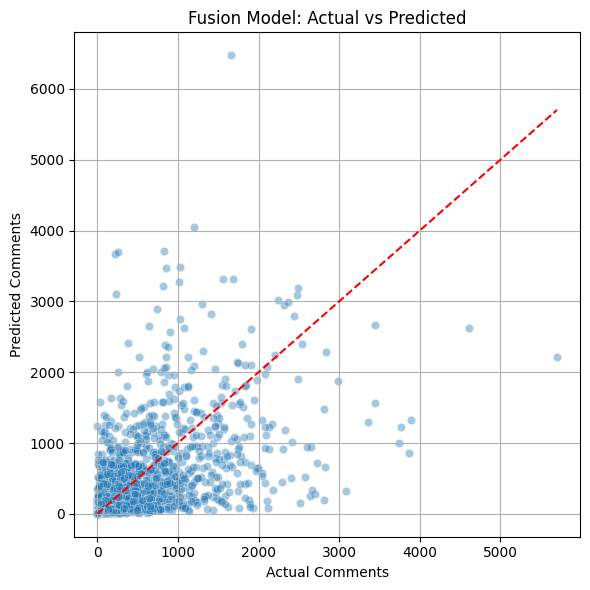

In [5]:
import pandas as pd
import numpy as np
import re, string
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout

# ---------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------
# df = pd.read_csv("your_dataset.csv")
# Example assumes df is already loaded
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

df['headline'] = df['headline'].fillna('').apply(clean_text)
df['abstract'] = df['abstract'].fillna('').apply(clean_text)
df['section'] = df['section'].fillna('').astype(str)

# Sentiment Features
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['headline_sentiment'] = df['headline'].apply(get_sentiment)
df['abstract_sentiment'] = df['abstract'].apply(get_sentiment)

# Numeric Features
df['headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.split()))
df['headline_char_count'] = df['headline'].apply(lambda x: len(x))
df['abstract_char_count'] = df['abstract'].apply(lambda x: len(x))
df['headline_avg_word_length'] = df['headline'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df['abstract_avg_word_length'] = df['abstract'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df['interaction_term'] = df['word_count'] * df['headline_word_count']
df['char_count_interaction'] = df['headline_char_count'] * df['abstract_char_count']

# Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = model.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = model.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = model.encode(df['section'].tolist(), show_progress_bar=True)

# Numeric features to scale
num_features = df[[
    'word_count', 'headline_word_count', 'abstract_word_count',
    'headline_char_count', 'abstract_char_count',
    'headline_avg_word_length', 'abstract_avg_word_length',
    'interaction_term', 'char_count_interaction',
    'headline_sentiment', 'abstract_sentiment'
]].values

scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_features)

# Target
y = np.log1p(df['n_comments'].values)

# Train-test split
X1_train, X1_test, \
X2_train, X2_test, \
X3_train, X3_test, \
Xnum_train, Xnum_test, \
y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_scaled, y,
    test_size=0.2, random_state=42
)

# ---------------------------------------
# Model Architecture
# [headline]→Dense(128)
# [abstract]→Dense(128)
# [section]→Dense(128)
#         → Concatenate → Dense → Output
# ---------------------------------------

# Inputs
inp_headline = Input(shape=(384,), name='headline_input')
inp_abstract = Input(shape=(384,), name='abstract_input')
inp_section = Input(shape=(384,), name='section_input')
inp_numeric = Input(shape=(Xnum_train.shape[1],), name='numeric_input')

# Individual Dense paths
h = Dense(128, activation='relu')(inp_headline)
a = Dense(128, activation='relu')(inp_abstract)
s = Dense(128, activation='relu')(inp_section)
n = Dense(64, activation='relu')(inp_numeric)

# Fusion and final layers
x = Concatenate()([h, a, s, n])
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x)

# Build and compile
fusion_model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
fusion_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

fusion_model.summary()

# ---------------------------------------
# Train
# ---------------------------------------
fusion_model.fit(
    [X1_train, X2_train, X3_train, Xnum_train], y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=2
)

# ---------------------------------------
# Evaluate
# ---------------------------------------
preds = fusion_model.predict([X1_test, X2_test, X3_test, Xnum_test])
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\nFusion Model Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Inverse log transform for plotting
y_actual = np.expm1(y_test)
preds_actual = np.expm1(preds)

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_actual, y=preds_actual.flatten(), alpha=0.4)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
plt.xlabel("Actual Comments")
plt.ylabel("Predicted Comments")
plt.title("Fusion Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# ---------------------------------------
# Data Preprocessing
# ---------------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

# Load dataset
df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

# Embeddings
model_st = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = model_st.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = model_st.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = model_st.encode(df['section'].tolist(), show_progress_bar=True)

# Numeric Features
df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['headline_len'] = df['headline'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)
df['interaction'] = df['word_count'] * df['headline_wc']

num_feats = df[['word_count', 'headline_wc', 'abstract_wc', 'headline_len', 'abstract_len', 'interaction']].values
scaler = StandardScaler()
num_feats_scaled = scaler.fit_transform(num_feats)

# Target
y = np.log1p(df['n_comments'].values)

# Train-test split
X1_train, X1_test, \
X2_train, X2_test, \
X3_train, X3_test, \
X4_train, X4_test, \
y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_feats_scaled, y,
    test_size=0.2, random_state=42
)

# ---------------------------------------
# Model Definition
# ---------------------------------------
def build_model():
    # Inputs
    inp_headline = Input(shape=(384,), name='headline_emb')
    inp_abstract = Input(shape=(384,), name='abstract_emb')
    inp_section = Input(shape=(384,), name='section_emb')
    inp_numeric = Input(shape=(X4_train.shape[1],), name='numeric_feats')

    # Dense paths with BatchNorm
    h1 = Dense(128, activation='relu')(inp_headline)
    h1 = BatchNormalization()(h1)

    h2 = Dense(128, activation='relu')(inp_abstract)
    h2 = BatchNormalization()(h2)

    h3 = Dense(128, activation='relu')(inp_section)
    h3 = BatchNormalization()(h3)

    h4 = Dense(64, activation='relu')(inp_numeric)
    h4 = BatchNormalization()(h4)

    # Fusion
    x = Concatenate()([h1, h2, h3, h4])
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

model = build_model()
model.summary()

# ---------------------------------------
# Training
# ---------------------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
]

history = model.fit(
    [X1_train, X2_train, X3_train, X4_train], y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# ---------------------------------------
# Evaluation
# ---------------------------------------
preds = model.predict([X1_test, X2_test, X3_test, X4_test]).flatten()
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\nFusion Model Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")


Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ headline_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_emb (InputLayer)  │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_feats             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 128)            │         49,280 │ headline_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 128)            │         49,280 │ abstract_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 128)            │         49,280 │ section_emb[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 64)             │            448 │ numeric_feats[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense_33[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ dense_34[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense_35[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64)             │            256 │ dense_36[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 448)            │              0 │ batch_normalization[0… │
│ (Concatenate)             │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 448)            │              0 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 128)            │         57,472 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)  

 Total params: 215,873 (843.25 KB)

 Trainable params: 214,977 (839.75 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
378/378 - 11s - 29ms/step - loss: 2.7742 - root_mean_squared_error: 1.6656 - val_loss: 7.8123 - val_root_mean_squared_error: 2.7951 - learning_rate: 0.0010
Epoch 2/30
378/378 - 1s - 2ms/step - loss: 1.6759 - root_mean_squared_error: 1.2946 - val_loss: 2.2012 - val_root_mean_squared_error: 1.4836 - learning_rate: 0.0010
Epoch 3/30
378/378 - 1s - 2ms/step - loss: 1.5143 - root_mean_squared_error: 1.2306 - val_loss: 1.7784 - val_root_mean_squared_error: 1.3336 - learning_rate: 0.0010
Epoch 4/30
378/378 - 1s - 2ms/step - loss: 1.3758 - root_mean_squared_error: 1.1729 - val_loss: 1.7352 - val_root_mean_squared_error: 1.3173 - learning_rate: 0.0010
Epoch 5/30
378/378 - 1s - 2ms/step - loss: 1.2732 - root_mean_squared_error: 1.1284 - val_loss: 1.8120 - val_root_mean_squared_error: 1.3461 - learning_rate: 0.0010
Epoch 6/30
378/378 - 1s - 2ms/step - loss: 1.1812 - root_mean_squared_error: 1.0868 - val_loss: 1.6050 - val_root_mean_squared_error: 1.2669 - learning_rate: 0.0010
Epoch 7/

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ headline_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_emb (InputLayer)  │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_feats             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 128)            │         49,280 │ headline_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_47 (Dense)          │ (None, 128)            │         49,280 │ abstract_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 128)            │         49,280 │ section_emb[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_49 (Dense)          │ (None, 64)             │            576 │ numeric_feats[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 128)            │            512 │ dense_46[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 128)            │            512 │ dense_47[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 128)            │            512 │ dense_48[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 64)             │            256 │ dense_49[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 448)            │              0 │ batch_normalization_9… │
│ (Concatenate)             │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 448)            │              0 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 128)            │         57,472 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 290,497 (1.11 MB)

 Trainable params: 289,345 (1.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/40
378/378 - 14s - 36ms/step - loss: 3.9298 - root_mean_squared_error: 1.9824 - val_loss: 3.6733 - val_root_mean_squared_error: 1.9166 - learning_rate: 0.0010
Epoch 2/40
378/378 - 1s - 3ms/step - loss: 1.8691 - root_mean_squared_error: 1.3671 - val_loss: 1.7990 - val_root_mean_squared_error: 1.3413 - learning_rate: 0.0010
Epoch 3/40
378/378 - 1s - 3ms/step - loss: 1.6289 - root_mean_squared_error: 1.2763 - val_loss: 1.6108 - val_root_mean_squared_error: 1.2692 - learning_rate: 0.0010
Epoch 4/40
378/378 - 1s - 3ms/step - loss: 1.4983 - root_mean_squared_error: 1.2241 - val_loss: 1.5225 - val_root_mean_squared_error: 1.2339 - learning_rate: 0.0010
Epoch 5/40
378/378 - 1s - 3ms/step - loss: 1.3641 - root_mean_squared_error: 1.1679 - val_loss: 1.6943 - val_root_mean_squared_error: 1.3017 - learning_rate: 0.0010
Epoch 6/40
378/378 - 1s - 3ms/step - loss: 1.2296 - root_mean_squared_error: 1.1089 - val_loss: 1.4883 - val_root_mean_squared_error: 1.2200 - learning_rate: 0.0010
Epoch 7/

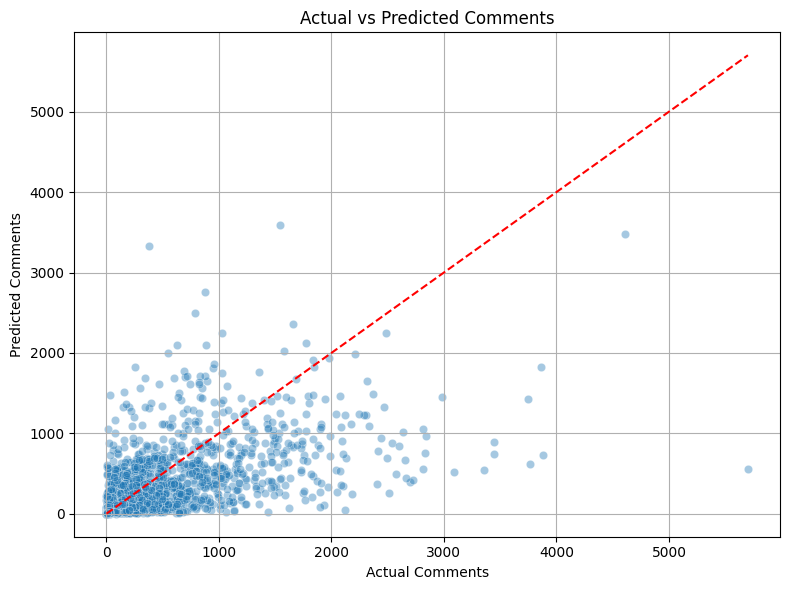

In [8]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sentence_transformers import SentenceTransformer
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Clean + Feature Engineering
# -------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Load dataset
df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

# Sentiment & Text Features
df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['headline_len'] = df['headline'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)
df['interaction'] = df['word_count'] * df['headline_wc']
df['headline_sentiment'] = df['headline'].apply(get_sentiment)
df['abstract_sentiment'] = df['abstract'].apply(get_sentiment)

# -------------------------------
# 2. Embeddings & Features
# -------------------------------
model_st = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = model_st.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = model_st.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = model_st.encode(df['section'].tolist(), show_progress_bar=True)

# Numerical features
num_feats = df[[
    'word_count', 'headline_wc', 'abstract_wc',
    'headline_len', 'abstract_len', 'interaction',
    'headline_sentiment', 'abstract_sentiment'
]].values

scaler = StandardScaler()
num_feats_scaled = scaler.fit_transform(num_feats)

# Target
y = np.log1p(df['n_comments'].values)

# Train-test split
X1_train, X1_test, \
X2_train, X2_test, \
X3_train, X3_test, \
X4_train, X4_test, \
y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_feats_scaled, y,
    test_size=0.2, random_state=42
)

# -------------------------------
# 3. Model Definition
# -------------------------------
def residual_dense(x, units):
    shortcut = Dense(units)(x)  # project input to match shape
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(units, activation='relu')(x)
    return Add()([shortcut, x])


def build_model():
    inp_headline = Input(shape=(384,), name='headline_emb')
    inp_abstract = Input(shape=(384,), name='abstract_emb')
    inp_section = Input(shape=(384,), name='section_emb')
    inp_numeric = Input(shape=(X4_train.shape[1],), name='numeric_feats')

    h1 = Dense(128, activation='relu')(inp_headline)
    h1 = BatchNormalization()(h1)

    h2 = Dense(128, activation='relu')(inp_abstract)
    h2 = BatchNormalization()(h2)

    h3 = Dense(128, activation='relu')(inp_section)
    h3 = BatchNormalization()(h3)

    h4 = Dense(64, activation='relu')(inp_numeric)
    h4 = BatchNormalization()(h4)

    # Merge all
    x = Concatenate()([h1, h2, h3, h4])
    x = Dropout(0.3)(x)
    x = residual_dense(x, 128)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-3, weight_decay=1e-4),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

model = build_model()
model.summary()

# -------------------------------
# 4. Training
# -------------------------------
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history = model.fit(
    [X1_train, X2_train, X3_train, X4_train], y_train,
    validation_split=0.1,
    epochs=40,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# -------------------------------
# 5. Evaluation
# -------------------------------
preds = model.predict([X1_test, X2_test, X3_test, X4_test]).flatten()
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\n⭐ Fusion Model Pro Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# -------------------------------
# 6. Visualization
# -------------------------------
y_test_actual = np.expm1(y_test)
preds_actual = np.expm1(preds)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=preds_actual, alpha=0.4)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], '--', color='red')
plt.xlabel("Actual Comments")
plt.ylabel("Predicted Comments")
plt.title("Actual vs Predicted Comments")
plt.grid(True)
plt.tight_layout()
plt.show()


Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ headline_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_emb (InputLayer)  │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ headline_dense (Dense)    │ (None, 128)            │         49,280 │ headline_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_dense (Dense)    │ (None, 128)            │         49,280 │ abstract_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_dense (Dense)     │ (None, 128)            │         49,280 │ section_emb[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ headline_bn               │ (None, 128)            │            512 │ headline_dense[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_bn               │ (None, 128)            │            512 │ abstract_dense[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_bn                │ (None, 128)            │            512 │ section_dense[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_feats             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ headline_drop (Dropout)   │ (None, 128)            │              0 │ headline_bn[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_drop (Dropout)   │ (None, 128)            │              0 │ abstract_bn[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_drop (Dropout)    │ (None, 128)            │              0 │ section_bn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_dense (Dense)     │ (None, 64)             │            576 │ numeric_feats[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fusion (Concatenate)      │ (None, 448)            │              0 │ headline_drop[0][0],   │
│                           │                        │                │ abstract_drop[0][0],   │
│                           │                        │                │ section_drop[0][0],    │
│                           │                        │                │ numeric_dense[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_56 (Dense)          │ (None, 256)            │        114,944 │ fusion[0][0]           │
├──────────────────────

 Total params: 539,329 (2.06 MB)

 Trainable params: 537,025 (2.05 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/40

Epoch 1: val_loss improved from inf to 2.63508, saving model to best_model.keras
378/378 - 20s - 52ms/step - loss: 4.5615 - rmse: 2.1358 - val_loss: 2.6351 - val_rmse: 1.6233 - learning_rate: 0.0010
Epoch 2/40

Epoch 2: val_loss improved from 2.63508 to 1.82259, saving model to best_model.keras
378/378 - 1s - 3ms/step - loss: 2.2671 - rmse: 1.5057 - val_loss: 1.8226 - val_rmse: 1.3500 - learning_rate: 0.0010
Epoch 3/40

Epoch 3: val_loss improved from 1.82259 to 1.64016, saving model to best_model.keras
378/378 - 1s - 4ms/step - loss: 1.9687 - rmse: 1.4031 - val_loss: 1.6402 - val_rmse: 1.2807 - learning_rate: 0.0010
Epoch 4/40

Epoch 4: val_loss improved from 1.64016 to 1.56612, saving model to best_model.keras
378/378 - 1s - 4ms/step - loss: 1.7773 - rmse: 1.3332 - val_loss: 1.5661 - val_rmse: 1.2514 - learning_rate: 0.0010
Epoch 5/40

Epoch 5: val_loss did not improve from 1.56612
378/378 - 1s - 3ms/step - loss: 1.6571 - rmse: 1.2873 - val_loss: 1.5833 - val_rmse: 1.2583

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


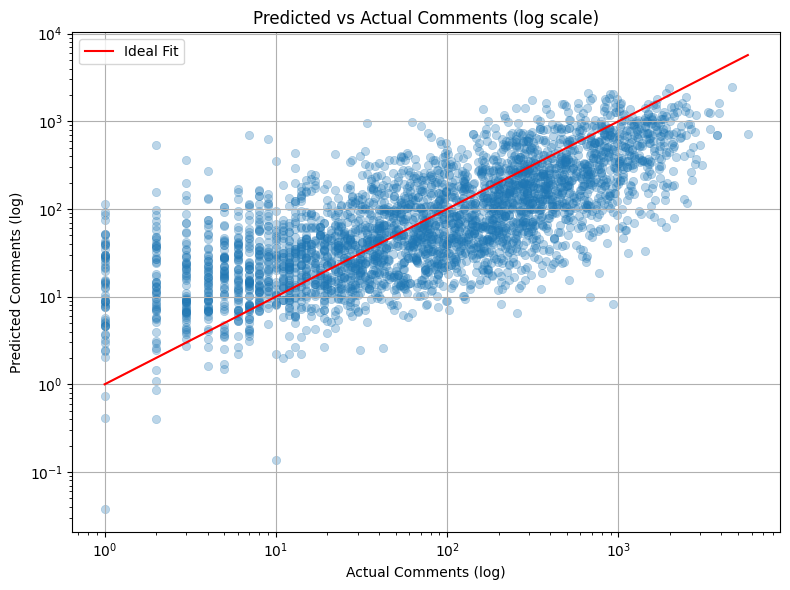

In [9]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sentence_transformers import SentenceTransformer
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Clean + Feature Engineering
# -------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Load dataset
df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

# Sentiment & Text Features
df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['headline_len'] = df['headline'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)
df['interaction'] = df['word_count'] * df['headline_wc']
df['headline_sentiment'] = df['headline'].apply(get_sentiment)
df['abstract_sentiment'] = df['abstract'].apply(get_sentiment)

# -------------------------------
# 2. Embeddings & Features
# -------------------------------
model_st = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = model_st.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = model_st.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = model_st.encode(df['section'].tolist(), show_progress_bar=True)

# Numerical features
num_feats = df[[
    'word_count', 'headline_wc', 'abstract_wc',
    'headline_len', 'abstract_len', 'interaction',
    'headline_sentiment', 'abstract_sentiment'
]].values

scaler = StandardScaler()
num_feats_scaled = scaler.fit_transform(num_feats)

# Target
y = np.log1p(df['n_comments'].values)

# Train-test split
X1_train, X1_test, \
X2_train, X2_test, \
X3_train, X3_test, \
X4_train, X4_test, \
y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_feats_scaled, y,
    test_size=0.2, random_state=42
)

# -------------------------------
# 3. Model Definition
# -------------------------------
def residual_dense(x, units, dropout_rate=0.1):
    shortcut = Dense(units)(x)
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    return Add()([shortcut, x])

def build_model():
    inp_headline = Input(shape=(384,), name='headline_emb')
    inp_abstract = Input(shape=(384,), name='abstract_emb')
    inp_section = Input(shape=(384,), name='section_emb')
    inp_numeric = Input(shape=(X4_train.shape[1],), name='numeric_feats')

    def branch_block(x, name):
        x = Dense(128, activation='relu', name=f"{name}_dense")(x)
        x = BatchNormalization(name=f"{name}_bn")(x)
        x = Dropout(0.2, name=f"{name}_drop")(x)
        return x

    h1 = branch_block(inp_headline, 'headline')
    h2 = branch_block(inp_abstract, 'abstract')
    h3 = branch_block(inp_section, 'section')
    h4 = Dense(64, activation='relu', name='numeric_dense')(inp_numeric)

    x = Concatenate(name='fusion')([h1, h2, h3, h4])
    x = residual_dense(x, 256, dropout_rate=0.3)
    x = residual_dense(x, 128, dropout_rate=0.2)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model

model = build_model()
model.summary()

# -------------------------------
# 4. Training
# -------------------------------
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint("best_model.keras", save_best_only=True, verbose=1)
]

history = model.fit(
    [X1_train, X2_train, X3_train, X4_train], y_train,
    validation_split=0.1,
    epochs=40,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# -------------------------------
# 5. Evaluation
# -------------------------------
preds = model.predict([X1_test, X2_test, X3_test, X4_test]).flatten()
preds = np.clip(preds, 0, None)  # Avoid negative predictions

rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\n📊 Final Model Results:")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ R^2: {r2:.4f}")

# -------------------------------
# 6. Visualization
# -------------------------------
y_test_actual = np.expm1(y_test)
preds_actual = np.expm1(preds)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=preds_actual, alpha=0.3, edgecolor=None)
sns.lineplot(x=y_test_actual, y=y_test_actual, color='red', label='Ideal Fit')
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Actual Comments (log)")
plt.ylabel("Predicted Comments (log)")
plt.title("Predicted vs Actual Comments (log scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ headline_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abstract_emb (InputLayer) │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_63 (Dense)          │ (None, 128)            │         49,280 │ headline_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_64 (Dense)          │ (None, 128)            │         49,280 │ abstract_emb[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ section_emb (InputLayer)  │ (None, 384)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 128)            │            512 │ dense_63[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 128)            │            512 │ dense_64[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_65 (Dense)          │ (None, 128)            │         49,280 │ section_emb[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_feats             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 128)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 128)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128)            │            512 │ dense_65[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_66 (Dense)          │ (None, 64)             │            576 │ numeric_feats[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 128)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 64)             │            256 │ dense_66[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)     │ (None, 128)            │              0 │ dropout_12[0][0],      │
│                           │                        │                │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_11       

 Total params: 605,121 (2.31 MB)

 Trainable params: 602,689 (2.30 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/50

Epoch 1: val_loss improved from inf to 2.86341, saving model to best_fusion_model.keras
378/378 - 21s - 54ms/step - loss: 4.1363 - rmse: 2.0338 - val_loss: 2.8634 - val_rmse: 1.6922 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 2.86341 to 1.66069, saving model to best_fusion_model.keras
378/378 - 2s - 6ms/step - loss: 2.3465 - rmse: 1.5318 - val_loss: 1.6607 - val_rmse: 1.2887 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss did not improve from 1.66069
378/378 - 1s - 3ms/step - loss: 1.8716 - rmse: 1.3681 - val_loss: 1.7118 - val_rmse: 1.3083 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 1.66069 to 1.61589, saving model to best_fusion_model.keras
378/378 - 1s - 4ms/step - loss: 1.7112 - rmse: 1.3081 - val_loss: 1.6159 - val_rmse: 1.2712 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 1.61589 to 1.50253, saving model to best_fusion_model.keras
378/378 - 1s - 4ms/step - loss: 1.5348 - rmse: 1.2389 - val_los

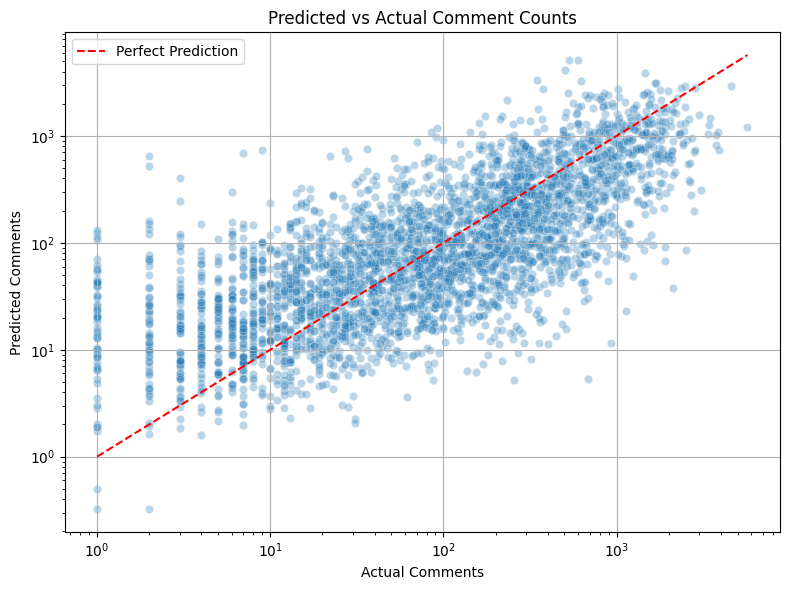

In [10]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sentence_transformers import SentenceTransformer
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Preprocessing
# -------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['headline_len'] = df['headline'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)
df['interaction'] = df['word_count'] * df['headline_wc']
df['headline_sentiment'] = df['headline'].apply(get_sentiment)
df['abstract_sentiment'] = df['abstract'].apply(get_sentiment)

# -------------------------------
# 2. Embeddings + Numeric Feats
# -------------------------------
model_st = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = model_st.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = model_st.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = model_st.encode(df['section'].tolist(), show_progress_bar=True)

num_feats = df[[
    'word_count', 'headline_wc', 'abstract_wc',
    'headline_len', 'abstract_len', 'interaction',
    'headline_sentiment', 'abstract_sentiment'
]].values
scaler = StandardScaler()
num_feats_scaled = scaler.fit_transform(num_feats)

y = np.log1p(df['n_comments'].values)

X1_train, X1_test, \
X2_train, X2_test, \
X3_train, X3_test, \
X4_train, X4_test, \
y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_feats_scaled, y,
    test_size=0.2, random_state=42
)

# -------------------------------
# 3. Model Definition
# -------------------------------
def residual_block(x, units, dropout_rate=0.2):
    shortcut = Dense(units)(x)
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    return Add()([shortcut, x])

def build_model():
    inp_headline = Input(shape=(384,), name='headline_emb')
    inp_abstract = Input(shape=(384,), name='abstract_emb')
    inp_section = Input(shape=(384,), name='section_emb')
    inp_numeric = Input(shape=(X4_train.shape[1],), name='numeric_feats')

    h1 = Dense(128, activation='relu')(inp_headline)
    h1 = BatchNormalization()(h1)
    h1 = Dropout(0.2)(h1)

    h2 = Dense(128, activation='relu')(inp_abstract)
    h2 = BatchNormalization()(h2)
    h2 = Dropout(0.2)(h2)

    h3 = Dense(128, activation='relu')(inp_section)
    h3 = BatchNormalization()(h3)
    h3 = Dropout(0.2)(h3)

    h4 = Dense(64, activation='relu')(inp_numeric)
    h4 = BatchNormalization()(h4)

    interaction = Multiply()([h1, h2])

    x = Concatenate()([h1, h2, h3, h4, interaction])
    x = residual_block(x, 256, dropout_rate=0.3)
    x = residual_block(x, 128, dropout_rate=0.2)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model

model = build_model()
model.summary()

# -------------------------------
# 4. Training
# -------------------------------
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint("best_fusion_model.keras", save_best_only=True, verbose=1)
]

history = model.fit(
    [X1_train, X2_train, X3_train, X4_train], y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# -------------------------------
# 5. Evaluation
# -------------------------------
preds = model.predict([X1_test, X2_test, X3_test, X4_test]).flatten()
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\n📊 Fusion Model Results:")
print(f"✅ RMSE (log space): {rmse:.4f}")
print(f"✅ MAE (log space): {mae:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# Convert to actual comment counts
y_test_actual = np.expm1(y_test)
preds_actual = np.expm1(preds)

# -------------------------------
# 6. Visualization
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=preds_actual, alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         '--', color='red', label="Perfect Prediction")
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Actual Comments")
plt.ylabel("Predicted Comments")
plt.title("Predicted vs Actual Comment Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
from tensorflow.keras.layers import Attention, Lambda
from tensorflow.keras.regularizers import l2

def attention_layer(query, key):
    attention = Attention()([query, key])
    return attention

def cross_interaction(x, y):
    # Element-wise multiplication and subtraction
    mult = Multiply()([x, y])
    sub = Lambda(lambda t: t[0] - t[1])([x, y])
    return Concatenate()([x, y, mult, sub])

def build_better_model():
    inp_headline = Input(shape=(384,), name='headline_emb')
    inp_abstract = Input(shape=(384,), name='abstract_emb')
    inp_section = Input(shape=(384,), name='section_emb')
    inp_numeric = Input(shape=(X4_train.shape[1],), name='numeric_feats')

    # Dense layers for each
    h1 = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(inp_headline)
    h1 = BatchNormalization()(h1)
    h1 = Dropout(0.3)(h1)

    h2 = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(inp_abstract)
    h2 = BatchNormalization()(h2)
    h2 = Dropout(0.3)(h2)

    h3 = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(inp_section)
    h3 = BatchNormalization()(h3)
    h3 = Dropout(0.2)(h3)

    h4 = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(inp_numeric)
    h4 = BatchNormalization()(h4)

    # Attention between headline and abstract
    headline_att = tf.expand_dims(h1, axis=1)
    abstract_att = tf.expand_dims(h2, axis=1)
    att_output = Attention()([headline_att, abstract_att])
    att_output = Lambda(lambda x: tf.squeeze(x, axis=1))(att_output)

    # Cross-interaction features
    cross_feats = cross_interaction(h1, h2)

    # Merge all
    x = Concatenate()([h1, h2, h3, h4, att_output, cross_feats])
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=tf.keras.losses.Huber(),
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model


In [13]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sentence_transformers import SentenceTransformer
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Preprocessing
# -------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['headline_len'] = df['headline'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)
df['interaction'] = df['word_count'] * df['headline_wc']
df['headline_sentiment'] = df['headline'].apply(get_sentiment)
df['abstract_sentiment'] = df['abstract'].apply(get_sentiment)

# -------------------------------
# 2. Embeddings + Numeric Feats
# -------------------------------
model_st = SentenceTransformer('all-MiniLM-L6-v2')
headline_embeddings = model_st.encode(df['headline'].tolist(), show_progress_bar=True)
abstract_embeddings = model_st.encode(df['abstract'].tolist(), show_progress_bar=True)
section_embeddings = model_st.encode(df['section'].tolist(), show_progress_bar=True)

num_feats = df[[
    'word_count', 'headline_wc', 'abstract_wc',
    'headline_len', 'abstract_len', 'interaction',
    'headline_sentiment', 'abstract_sentiment'
]].values
scaler = StandardScaler()
num_feats_scaled = scaler.fit_transform(num_feats)

y = np.log1p(df['n_comments'].values)

X1_train, X1_test, \
X2_train, X2_test, \
X3_train, X3_test, \
X4_train, X4_test, \
y_train, y_test = train_test_split(
    headline_embeddings, abstract_embeddings, section_embeddings, num_feats_scaled, y,
    test_size=0.2, random_state=42
)

# -------------------------------
# 3. Model Definition
# -------------------------------
def residual_block(x, units, dropout_rate=0.2):
    shortcut = Dense(units)(x)
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    return Add()([shortcut, x])

def build_model():
    inp_headline = Input(shape=(384,), name='headline_emb')
    inp_abstract = Input(shape=(384,), name='abstract_emb')
    inp_section = Input(shape=(384,), name='section_emb')
    inp_numeric = Input(shape=(X4_train.shape[1],), name='numeric_feats')

    h1 = Dense(128, activation='relu')(inp_headline)
    h1 = BatchNormalization()(h1)
    h1 = Dropout(0.2)(h1)

    h2 = Dense(128, activation='relu')(inp_abstract)
    h2 = BatchNormalization()(h2)
    h2 = Dropout(0.2)(h2)

    h3 = Dense(128, activation='relu')(inp_section)
    h3 = BatchNormalization()(h3)
    h3 = Dropout(0.2)(h3)

    h4 = Dense(64, activation='relu')(inp_numeric)
    h4 = BatchNormalization()(h4)

    interaction = Multiply()([h1, h2])

    x = Concatenate()([h1, h2, h3, h4, interaction])
    x = residual_block(x, 256, dropout_rate=0.3)
    x = residual_block(x, 128, dropout_rate=0.2)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[inp_headline, inp_abstract, inp_section, inp_numeric], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model

model = build_better_model()
model.summary()

# -------------------------------
# 4. Training
# -------------------------------
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint("best_fusion_model.keras", save_best_only=True, verbose=1)
]

history = model.fit(
    [X1_train, X2_train, X3_train, X4_train], y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# -------------------------------
# 5. Evaluation
# -------------------------------
preds = model.predict([X1_test, X2_test, X3_test, X4_test]).flatten()
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\n📊 Fusion Model Results:")
print(f"✅ RMSE (log space): {rmse:.4f}")
print(f"✅ MAE (log space): {mae:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# Convert to actual comment counts
y_test_actual = np.expm1(y_test)
preds_actual = np.expm1(preds)

# -------------------------------
# 6. Visualization
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=preds_actual, alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         '--', color='red', label="Perfect Prediction")
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Actual Comments")
plt.ylabel("Predicted Comments")
plt.title("Predicted vs Actual Comment Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

Batches:   0%|          | 0/525 [00:00<?, ?it/s]

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [1]:
import numpy as np
import pandas as pd
import re, string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sentence_transformers import SentenceTransformer
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Load dataset
df = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")
df = df[['headline', 'abstract', 'section', 'word_count', 'n_comments']].dropna()

df['headline'] = df['headline'].apply(clean_text)
df['abstract'] = df['abstract'].apply(clean_text)
df['section'] = df['section'].astype(str).apply(clean_text)

# Sentiment & Text Features
df['headline_wc'] = df['headline'].apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].apply(lambda x: len(x.split()))
df['headline_len'] = df['headline'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)
df['interaction'] = df['word_count'] * df['headline_wc']
df['headline_sentiment'] = df['headline'].apply(get_sentiment)
df['abstract_sentiment'] = df['abstract'].apply(get_sentiment)

2025-04-22 17:00:16.565276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745341216.806202      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745341216.878835      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
MAX_LEN = 64



df['n_comments'] = np.log1p(df['n_comments'])  # log-transform
numeric_cols = [
    'word_count', 'headline_wc', 'abstract_wc',
    'headline_len', 'abstract_len', 'interaction',
    'headline_sentiment', 'abstract_sentiment'
]

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Dataset
class MultiInputDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def encode_text(self, text):
        encoded = self.tokenizer(text, truncation=True, max_length=self.max_len,
                                 padding='max_length', return_tensors='pt')
        return encoded['input_ids'].squeeze(0), encoded['attention_mask'].squeeze(0)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        headline_ids, headline_mask = self.encode_text(row['headline'])
        abstract_ids, abstract_mask = self.encode_text(row['abstract'])
        section_ids, section_mask = self.encode_text(row['section'])

        numeric = torch.tensor(row[numeric_cols].values.astype(np.float32))
        target = torch.tensor(row['n_comments'], dtype=torch.float)

        return {
            'headline_ids': headline_ids,
            'headline_mask': headline_mask,
            'abstract_ids': abstract_ids,
            'abstract_mask': abstract_mask,
            'section_ids': section_ids,
            'section_mask': section_mask,
            'numeric': numeric,
            'target': target
        }

# Model
class CustomRegressor(nn.Module):
    def __init__(self, model_name=MODEL_NAME):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.embedding_dim = 384  # we'll reduce BERT output from 768 → 384 using a linear layer
        self.projection = nn.Linear(self.bert.config.hidden_size, self.embedding_dim)

        self.headline_proj = nn.Sequential(nn.Linear(self.embedding_dim, 128), nn.BatchNorm1d(128))
        self.abstract_proj = nn.Sequential(nn.Linear(self.embedding_dim, 128), nn.BatchNorm1d(128))
        self.section_proj = nn.Sequential(nn.Linear(self.embedding_dim, 128), nn.BatchNorm1d(128))
        self.numeric_proj = nn.Sequential(nn.Linear(8, 128), nn.BatchNorm1d(128))

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Sequential(nn.Linear(128 * 4, 128), nn.BatchNorm1d(128), nn.ReLU())
        self.fc2 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 1)

    def get_embedding(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        cls_embed = out[:, 0, :]  # CLS token
        return self.projection(cls_embed)

    def forward(self, headline_ids, headline_mask, abstract_ids, abstract_mask,
                section_ids, section_mask, numeric):
        h = self.get_embedding(headline_ids, headline_mask)
        a = self.get_embedding(abstract_ids, abstract_mask)
        s = self.get_embedding(section_ids, section_mask)

        h = self.headline_proj(h)
        a = self.abstract_proj(a)
        s = self.section_proj(s)
        n = self.numeric_proj(numeric)

        x = torch.cat([h, a, s, n], dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        res = self.fc2(x)
        x = x + res  # Residual
        return self.output_layer(x).squeeze()

# Train-test split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = MultiInputDataset(X_train, tokenizer)
test_dataset = MultiInputDataset(X_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Init model
model = CustomRegressor().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()

        outputs = model(
            batch['headline_ids'].to(DEVICE),
            batch['headline_mask'].to(DEVICE),
            batch['abstract_ids'].to(DEVICE),
            batch['abstract_mask'].to(DEVICE),
            batch['section_ids'].to(DEVICE),
            batch['section_mask'].to(DEVICE),
            batch['numeric'].to(DEVICE),
        )
        loss = loss_fn(outputs, batch['target'].to(DEVICE))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        preds = model(
            batch['headline_ids'].to(DEVICE),
            batch['headline_mask'].to(DEVICE),
            batch['abstract_ids'].to(DEVICE),
            batch['abstract_mask'].to(DEVICE),
            batch['section_ids'].to(DEVICE),
            batch['section_mask'].to(DEVICE),
            batch['numeric'].to(DEVICE),
        )
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch['target'].cpu().numpy())

# Metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

rmse = mean_squared_error(all_targets, all_preds, squared=False)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print("\n🧠 Custom NN Regression Results (log scale):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Optional: back-transform predictions
real_preds = np.expm1(all_preds)
real_targets = np.expm1(all_targets)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 840/840 [07:23<00:00,  1.89it/s]


Epoch 1 Loss: 6.7387


Epoch 2: 100%|██████████| 840/840 [07:28<00:00,  1.87it/s]


Epoch 2 Loss: 1.6745


Epoch 3: 100%|██████████| 840/840 [07:28<00:00,  1.87it/s]


Epoch 3 Loss: 1.3604

🧠 Custom NN Regression Results (log scale):
RMSE: 1.4285
MAE: 1.1458
R^2: 0.3412


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
MAX_LEN = 64



df['n_comments'] = np.log1p(df['n_comments'])  # log-transform
numeric_cols = [
    'word_count', 'headline_wc', 'abstract_wc',
    'headline_len', 'abstract_len', 'interaction',
    'headline_sentiment', 'abstract_sentiment'
]

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Dataset
class MultiInputDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def encode_text(self, text):
        encoded = self.tokenizer(text, truncation=True, max_length=self.max_len,
                                 padding='max_length', return_tensors='pt')
        return encoded['input_ids'].squeeze(0), encoded['attention_mask'].squeeze(0)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        headline_ids, headline_mask = self.encode_text(row['headline'])
        abstract_ids, abstract_mask = self.encode_text(row['abstract'])
        section_ids, section_mask = self.encode_text(row['section'])

        numeric = torch.tensor(row[numeric_cols].values.astype(np.float32))
        target = torch.tensor(row['n_comments'], dtype=torch.float)

        return {
            'headline_ids': headline_ids,
            'headline_mask': headline_mask,
            'abstract_ids': abstract_ids,
            'abstract_mask': abstract_mask,
            'section_ids': section_ids,
            'section_mask': section_mask,
            'numeric': numeric,
            'target': target
        }

# Model
class CustomRegressor(nn.Module):
    def __init__(self, model_name=MODEL_NAME):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.embedding_dim = 384  # we'll reduce BERT output from 768 → 384 using a linear layer
        self.projection = nn.Linear(self.bert.config.hidden_size, self.embedding_dim)

        self.headline_proj = nn.Sequential(nn.Linear(self.embedding_dim, 128), nn.BatchNorm1d(128))
        self.abstract_proj = nn.Sequential(nn.Linear(self.embedding_dim, 128), nn.BatchNorm1d(128))
        self.section_proj = nn.Sequential(nn.Linear(self.embedding_dim, 128), nn.BatchNorm1d(128))
        self.numeric_proj = nn.Sequential(nn.Linear(8, 128), nn.BatchNorm1d(128))

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Sequential(nn.Linear(128 * 4, 128), nn.BatchNorm1d(128), nn.ReLU())
        self.fc2 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 1)

    def get_embedding(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        cls_embed = out[:, 0, :]  # CLS token
        return self.projection(cls_embed)

    def forward(self, headline_ids, headline_mask, abstract_ids, abstract_mask,
                section_ids, section_mask, numeric):
        h = self.get_embedding(headline_ids, headline_mask)
        a = self.get_embedding(abstract_ids, abstract_mask)
        s = self.get_embedding(section_ids, section_mask)

        h = self.headline_proj(h)
        a = self.abstract_proj(a)
        s = self.section_proj(s)
        n = self.numeric_proj(numeric)

        x = torch.cat([h, a, s, n], dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        res = self.fc2(x)
        x = x + res  # Residual
        return self.output_layer(x).squeeze()

# Train-test split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = MultiInputDataset(X_train, tokenizer)
test_dataset = MultiInputDataset(X_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Init model
model = CustomRegressor().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()

        outputs = model(
            batch['headline_ids'].to(DEVICE),
            batch['headline_mask'].to(DEVICE),
            batch['abstract_ids'].to(DEVICE),
            batch['abstract_mask'].to(DEVICE),
            batch['section_ids'].to(DEVICE),
            batch['section_mask'].to(DEVICE),
            batch['numeric'].to(DEVICE),
        )
        loss = loss_fn(outputs, batch['target'].to(DEVICE))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        preds = model(
            batch['headline_ids'].to(DEVICE),
            batch['headline_mask'].to(DEVICE),
            batch['abstract_ids'].to(DEVICE),
            batch['abstract_mask'].to(DEVICE),
            batch['section_ids'].to(DEVICE),
            batch['section_mask'].to(DEVICE),
            batch['numeric'].to(DEVICE),
        )
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch['target'].cpu().numpy())

# Metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

rmse = mean_squared_error(all_targets, all_preds, squared=False)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print("\n🧠 Custom NN Regression Results (log scale):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Optional: back-transform predictions
real_preds = np.expm1(all_preds)
real_targets = np.expm1(all_targets)


Epoch 1: 100%|██████████| 840/840 [07:29<00:00,  1.87it/s]


Epoch 1 Loss: 0.4251


Epoch 2: 100%|██████████| 840/840 [07:29<00:00,  1.87it/s]


Epoch 2 Loss: 0.1381


Epoch 3: 100%|██████████| 840/840 [07:29<00:00,  1.87it/s]


Epoch 3 Loss: 0.1144


Epoch 4:   6%|▌         | 47/840 [00:25<07:13,  1.83it/s]


KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim import AdamW
from tqdm import tqdm
from transformers import pipeline
# Load sentiment pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def get_sentiment_score(text):
    try:
        result = sentiment_analyzer(text[:512])[0]  # truncate long inputs
        score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
        return score
    except:
        return 0.0  # fallback if tokenizer fails


# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
MAX_LEN = 128
articles_path = "/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv"
# Load data
df = pd.read_csv(articles_path)
df['headline'] = df['headline'].fillna('').str.lower()
df['abstract'] = df['abstract'].fillna('').str.lower()
df['section'] = df['section'].fillna('').astype(str).str.lower()

# Numeric features
df['word_count'] = df['abstract'].str.split().apply(len)
df['headline_wc'] = df['headline'].str.split().apply(len)
df['abstract_wc'] = df['abstract'].str.split().apply(len)
df['headline_len'] = df['headline'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)
df['interaction'] = df['headline_wc'] * df['abstract_wc']

df['headline_sentiment'] = df['headline'].apply(get_sentiment_score)
df['abstract_sentiment'] = df['abstract'].apply(get_sentiment_score)

numeric_cols = [
    'word_count', 'headline_wc', 'abstract_wc',
    'headline_len', 'abstract_len', 'interaction',
    'headline_sentiment', 'abstract_sentiment'
]

df['n_comments'] = np.log1p(df['n_comments'])  # Target

X = df[['headline', 'abstract', 'section'] + numeric_cols]
y = df['n_comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Dataset
class NYTMultiInputDataset(Dataset):
    def __init__(self, df, targets, tokenizer, max_len=MAX_LEN):
        self.headlines = df['headline'].tolist()
        self.abstracts = df['abstract'].tolist()
        self.sections = df['section'].tolist()
        self.numeric_feats = df[numeric_cols].values.astype(np.float32)
        self.targets = targets.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.headlines)

    def __getitem__(self, idx):
        headline = self.headlines[idx]
        abstract = self.abstracts[idx]
        section = self.sections[idx]
        numeric = torch.tensor(self.numeric_feats[idx], dtype=torch.float)

        h_enc = self.tokenizer(headline, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        a_enc = self.tokenizer(abstract, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        s_enc = self.tokenizer(section, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'h_ids': h_enc['input_ids'].squeeze(),
            'h_mask': h_enc['attention_mask'].squeeze(),
            'a_ids': a_enc['input_ids'].squeeze(),
            'a_mask': a_enc['attention_mask'].squeeze(),
            's_ids': s_enc['input_ids'].squeeze(),
            's_mask': s_enc['attention_mask'].squeeze(),
            'numeric_feats': numeric,
            'target': torch.tensor(self.targets[idx], dtype=torch.float)
        }

# Model
class MultiModalBERTRegressor(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_features=8):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(3 * hidden_size + num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, h_ids, h_mask, a_ids, a_mask, s_ids, s_mask, numeric_feats):
        h_output = self.bert(h_ids, attention_mask=h_mask).pooler_output
        a_output = self.bert(a_ids, attention_mask=a_mask).pooler_output
        s_output = self.bert(s_ids, attention_mask=s_mask).pooler_output
        concat = torch.cat([h_output, a_output, s_output, numeric_feats], dim=1)
        return self.head(concat).squeeze()

# Prepare Dataloaders
train_dataset = NYTMultiInputDataset(X_train, y_train, tokenizer)
test_dataset = NYTMultiInputDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Train
model = MultiModalBERTRegressor().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        h_ids = batch['h_ids'].to(DEVICE)
        h_mask = batch['h_mask'].to(DEVICE)
        a_ids = batch['a_ids'].to(DEVICE)
        a_mask = batch['a_mask'].to(DEVICE)
        s_ids = batch['s_ids'].to(DEVICE)
        s_mask = batch['s_mask'].to(DEVICE)
        feats = batch['numeric_feats'].to(DEVICE)
        targets = batch['target'].to(DEVICE)

        optimizer.zero_grad()
        preds = model(h_ids, h_mask, a_ids, a_mask, s_ids, s_mask, feats)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch in test_loader:
        h_ids = batch['h_ids'].to(DEVICE)
        h_mask = batch['h_mask'].to(DEVICE)
        a_ids = batch['a_ids'].to(DEVICE)
        a_mask = batch['a_mask'].to(DEVICE)
        s_ids = batch['s_ids'].to(DEVICE)
        s_mask = batch['s_mask'].to(DEVICE)
        feats = batch['numeric_feats'].to(DEVICE)
        targets = batch['target'].to(DEVICE)

        preds = model(h_ids, h_mask, a_ids, a_mask, s_ids, s_mask, feats)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

rmse = mean_squared_error(all_targets, all_preds, squared=False)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print("\n📊 Multi-Input BERT Regression Results (log scale):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Optional: Inverse Transform
actual_preds = np.expm1(all_preds)
actual_targets = np.expm1(all_targets)


2025-04-22 18:49:24.789664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745347764.812063     184 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745347764.818958     184 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Epoch 1: 100%|██████████| 840/840 [13:53<00:00,  1.01it/s]


Epoch 1 Loss: 2.6690


Epoch 2: 100%|██████████| 840/840 [13:52<00:00,  1.01it/s]


Epoch 2 Loss: 1.5848


Epoch 3: 100%|██████████| 840/840 [13:52<00:00,  1.01it/s]


Epoch 3 Loss: 1.1419

📊 Multi-Input BERT Regression Results (log scale):
RMSE: 1.2257
MAE: 0.9576
R^2: 0.5230


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim import AdamW
from tqdm import tqdm
from transformers import pipeline
# Load sentiment pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def get_sentiment_score(text):
    try:
        result = sentiment_analyzer(text[:512])[0]  # truncate long inputs
        score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
        return score
    except:
        return 0.0  # fallback if tokenizer fails


# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
MAX_LEN = 128
articles_path = "/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv"
# Load data
df = pd.read_csv(articles_path)
df['headline'] = df['headline'].fillna('').str.lower()
df['abstract'] = df['abstract'].fillna('').str.lower()
df['section'] = df['section'].fillna('').astype(str).str.lower()

# Numeric features
df['word_count'] = df['abstract'].str.split().apply(len)
df['headline_wc'] = df['headline'].str.split().apply(len)
df['abstract_wc'] = df['abstract'].str.split().apply(len)
df['headline_len'] = df['headline'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)
df['interaction'] = df['headline_wc'] * df['abstract_wc']

df['headline_sentiment'] = df['headline'].apply(get_sentiment_score)
df['abstract_sentiment'] = df['abstract'].apply(get_sentiment_score)



numeric_cols = [
    'word_count', 'headline_wc', 'abstract_wc',
    'headline_len', 'abstract_len', 'interaction',
    'headline_sentiment', 'abstract_sentiment'
]

# Normalize numeric features
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Target transformation
df['n_comments'] = np.log1p(df['n_comments'])

# Split
X = df[['headline', 'abstract', 'section'] + numeric_cols]
y = df['n_comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Dataset
class NYTMultiInputDataset(Dataset):
    def __init__(self, df, targets, tokenizer, max_len=MAX_LEN):
        self.headlines = df['headline'].tolist()
        self.abstracts = df['abstract'].tolist()
        self.sections = df['section'].tolist()
        self.numeric_feats = df[numeric_cols].values.astype(np.float32)
        self.targets = targets.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.headlines)

    def __getitem__(self, idx):
        headline = self.headlines[idx]
        abstract = self.abstracts[idx]
        section = self.sections[idx]
        numeric = torch.tensor(self.numeric_feats[idx], dtype=torch.float)

        h_enc = self.tokenizer(headline, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        a_enc = self.tokenizer(abstract, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        s_enc = self.tokenizer(section, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'h_ids': h_enc['input_ids'].squeeze(),
            'h_mask': h_enc['attention_mask'].squeeze(),
            'a_ids': a_enc['input_ids'].squeeze(),
            'a_mask': a_enc['attention_mask'].squeeze(),
            's_ids': s_enc['input_ids'].squeeze(),
            's_mask': s_enc['attention_mask'].squeeze(),
            'numeric_feats': numeric,
            'target': torch.tensor(self.targets[idx], dtype=torch.float)
        }

# Model with mean pooling
class MultiModalBERTRegressor(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_features=8):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(3 * hidden_size + num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

        # Optional: freeze first few layers
        for name, param in self.bert.named_parameters():
            if "encoder.layer.0" in name or "encoder.layer.1" in name:
                param.requires_grad = False

    def mean_pooling(self, last_hidden_state, mask):
        mask = mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask, 1)
        sum_mask = torch.clamp(mask.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, h_ids, h_mask, a_ids, a_mask, s_ids, s_mask, numeric_feats):
        h_emb = self.mean_pooling(self.bert(h_ids, attention_mask=h_mask).last_hidden_state, h_mask)
        a_emb = self.mean_pooling(self.bert(a_ids, attention_mask=a_mask).last_hidden_state, a_mask)
        s_emb = self.mean_pooling(self.bert(s_ids, attention_mask=s_mask).last_hidden_state, s_mask)
        concat = torch.cat([h_emb, a_emb, s_emb, numeric_feats], dim=1)
        return self.head(concat).squeeze()

# Dataloaders
train_dataset = NYTMultiInputDataset(X_train, y_train, tokenizer)
test_dataset = NYTMultiInputDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Training
model = MultiModalBERTRegressor().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        h_ids = batch['h_ids'].to(DEVICE)
        h_mask = batch['h_mask'].to(DEVICE)
        a_ids = batch['a_ids'].to(DEVICE)
        a_mask = batch['a_mask'].to(DEVICE)
        s_ids = batch['s_ids'].to(DEVICE)
        s_mask = batch['s_mask'].to(DEVICE)
        feats = batch['numeric_feats'].to(DEVICE)
        targets = batch['target'].to(DEVICE)

        optimizer.zero_grad()
        preds = model(h_ids, h_mask, a_ids, a_mask, s_ids, s_mask, feats)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch in test_loader:
        h_ids = batch['h_ids'].to(DEVICE)
        h_mask = batch['h_mask'].to(DEVICE)
        a_ids = batch['a_ids'].to(DEVICE)
        a_mask = batch['a_mask'].to(DEVICE)
        s_ids = batch['s_ids'].to(DEVICE)
        s_mask = batch['s_mask'].to(DEVICE)
        feats = batch['numeric_feats'].to(DEVICE)
        targets = batch['target'].to(DEVICE)

        preds = model(h_ids, h_mask, a_ids, a_mask, s_ids, s_mask, feats)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

rmse = mean_squared_error(all_targets, all_preds, squared=False)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print("\n📊 Enhanced Multi-Input BERT Regression (log scale):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Optional: Back-transform
actual_preds = np.expm1(all_preds)
actual_targets = np.expm1(all_targets)


Device set to use cuda:0
Epoch 1: 100%|██████████| 840/840 [12:32<00:00,  1.12it/s]


Epoch 1 Loss: 2.4042


Epoch 2: 100%|██████████| 840/840 [12:32<00:00,  1.12it/s]


Epoch 2 Loss: 1.5345


Epoch 3: 100%|██████████| 840/840 [12:32<00:00,  1.12it/s]


Epoch 3 Loss: 1.1758

📊 Enhanced Multi-Input BERT Regression (log scale):
RMSE: 1.2795
MAE: 0.9911
R^2: 0.4802
